In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np


In [2]:

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the data
x_train, x_test = x_train / 255.0, x_test / 255.0


170498071/170498071 [==============================] - 3s 0us/step


In [3]:

# Split the dataset: 60% train, 20% validation, 20% test
num_train = int(0.6 * len(x_train))
num_val = int(0.2 * len(x_train))
x_val, y_val = x_train[num_train:num_train + num_val], y_train[num_train:num_train + num_val]
x_train, y_train = x_train[:num_train], y_train[:num_train]


In [4]:

# One-hot encode the labels
y_train = to_categorical(y_train, 10)
y_val = to_categorical(y_val, 10)
y_test = to_categorical(y_test, 10)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)
datagen.fit(x_train)


In [5]:

# Load the EfficientNetB2 model, pretrained on ImageNet, excluding the top (fully connected) layers
effnet_base = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Create a new model on top of the base EfficientNetB2
model = models.Sequential()
model.add(effnet_base)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))

# Compile the model
optimizer = optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


31790344/31790344 [==============================] - 0s 0us/step


In [6]:

# Train the model
history = model.fit(datagen.flow(x_train, y_train, batch_size=64),
                    epochs=50,
                    validation_data=(x_val, y_val))


Epoch 1/50
469/469 [==============================] - 111s 115ms/step - loss: 2.3086 - accuracy: 0.1964 - val_loss: 2.4464 - val_accuracy: 0.0988
Epoch 2/50
469/469 [==============================] - 48s 103ms/step - loss: 1.8114 - accuracy: 0.3496 - val_loss: 2.3582 - val_accuracy: 0.1774
Epoch 3/50
469/469 [==============================] - 50s 106ms/step - loss: 1.5662 - accuracy: 0.4409 - val_loss: 2.2189 - val_accuracy: 0.2988
Epoch 4/50
469/469 [==============================] - 49s 104ms/step - loss: 1.4198 - accuracy: 0.4979 - val_loss: 1.8769 - val_accuracy: 0.3942
Epoch 5/50
469/469 [==============================] - 50s 107ms/step - loss: 1.2942 - accuracy: 0.5440 - val_loss: 2.2291 - val_accuracy: 0.1979
Epoch 6/50
469/469 [==============================] - 48s 102ms/step - loss: 1.1992 - accuracy: 0.5826 - val_loss: 1.9893 - val_accuracy: 0.3679
Epoch 7/50
469/469 [==============================] - 47s 100ms/step - loss: 1.1084 - accuracy: 0.6177 - val_loss: 1.9855 - val_a

In [7]:

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc}")


313/313 [==============================] - 4s 12ms/step - loss: 1.7304 - accuracy: 0.5859
Test accuracy: 0.5859000086784363


313/313 [==============================] - 7s 15ms/step


<Figure size 1000x800 with 0 Axes>

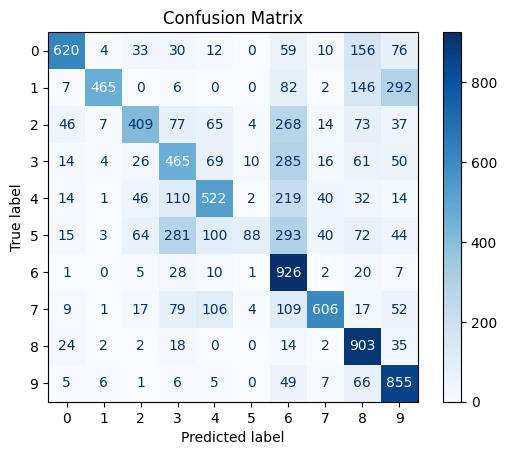

In [8]:

# Confusion matrix
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(i) for i in range(10)])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


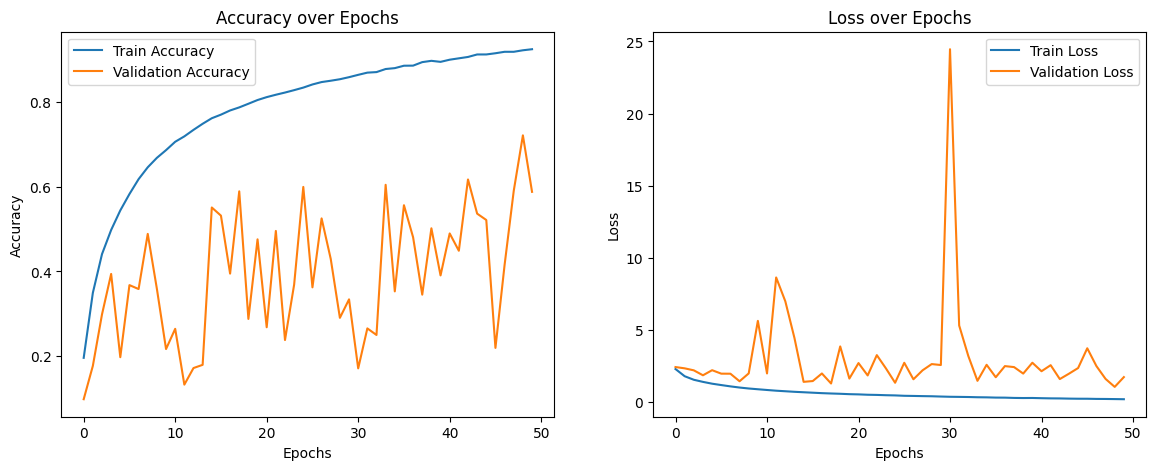

In [9]:

# Plot accuracy and loss over epochs
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


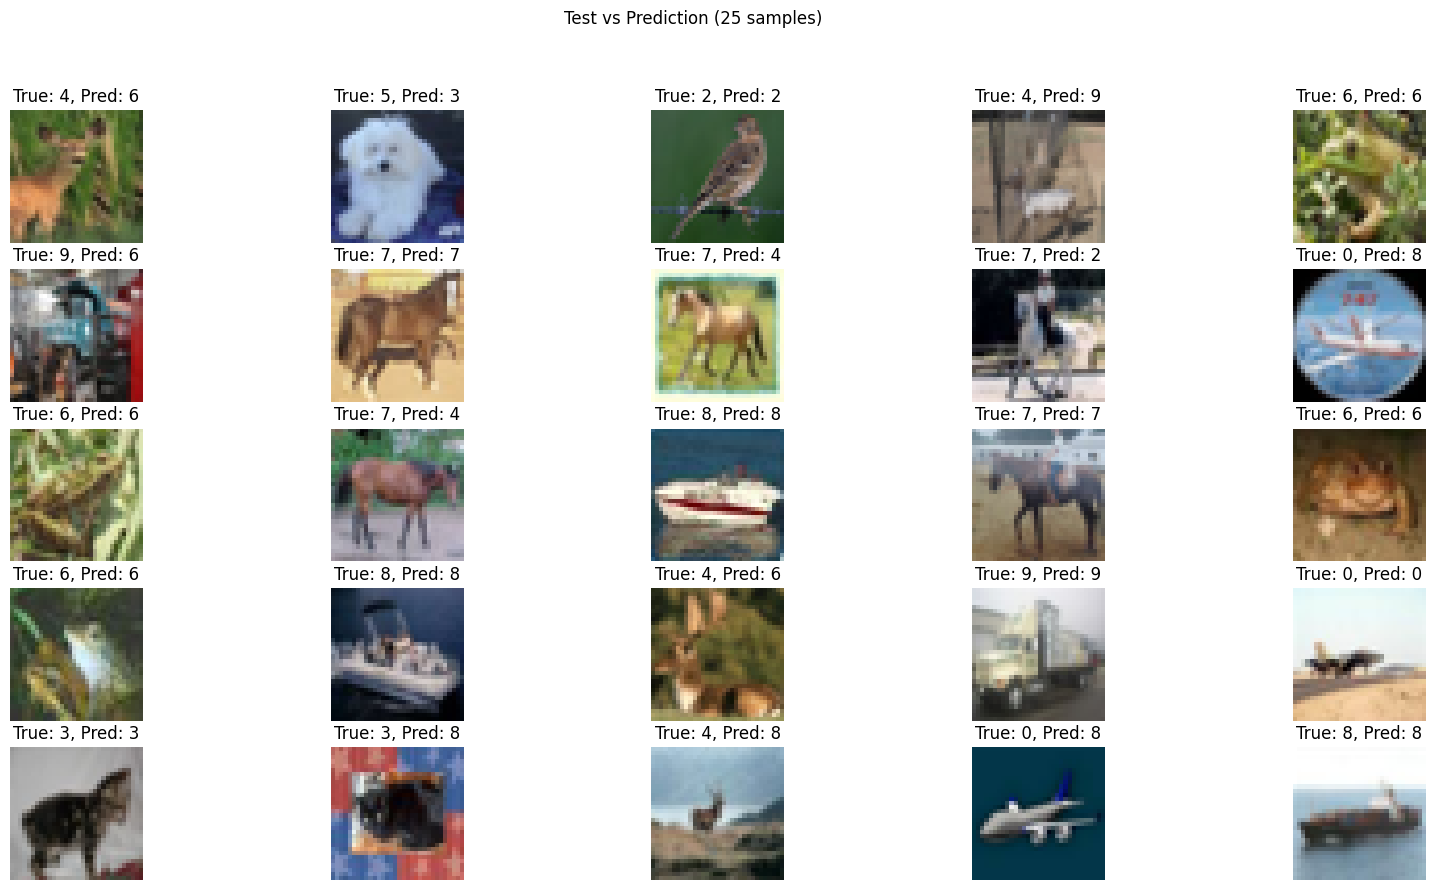

In [10]:

# Test vs. prediction plot over 25 samples
num_samples = 25
samples_idx = np.random.choice(len(x_test), num_samples)
x_samples = x_test[samples_idx]
y_true_samples = y_true[samples_idx]
y_pred_samples = y_pred_classes[samples_idx]

plt.figure(figsize=(20, 10))
for i in range(num_samples):
    plt.subplot(5, 5, i+1)
    plt.imshow(x_samples[i])
    plt.title(f"True: {y_true_samples[i]}, Pred: {y_pred_samples[i]}")
    plt.axis('off')
plt.suptitle("Test vs Prediction (25 samples)")
plt.show()
